In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
# Load the dataset
df = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')

In [13]:
# Display the first few rows
print(df.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [14]:
# Get a summary of the dataset
print(df.info())
print('\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [15]:
# Check for missing values
print(df.isnull().sum())

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [17]:
# Fill missing values for text columns
text_columns = ['location', 'company_profile', 'description', 'requirements', 
                'benefits', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

df[text_columns] = df[text_columns].fillna('Unknown')

In [18]:
# Split the data into text-based and numeric-based features
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
numeric_columns = ['telecommuting', 'has_company_logo', 'has_questions']

In [21]:
# Prepare text-based data
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df[text_columns].apply(lambda x: ' '.join(x), axis=1))

In [23]:
# Convert text to sequences
text_sequences = tokenizer.texts_to_sequences(df[text_columns].apply(lambda x: ' '.join(x), axis=1))
padded_sequences = pad_sequences(text_sequences, maxlen=max_len)

In [24]:
# Prepare numeric features
X_numeric = df[numeric_columns].values

# Combine numeric and text features for input
X_text = np.array(padded_sequences)

# Label target variable
y = df['fraudulent'].values

In [26]:
# Train-test split
X_train_text, X_test_text, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

In [27]:
# Build the RNN model
# Text input (for sequences)
text_input = Input(shape=(max_len,), name='text_input')
x = Embedding(input_dim=max_words, output_dim=128)(text_input)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.5)(x)

In [28]:
# Numeric input
numeric_input = Input(shape=(X_numeric.shape[1],), name='numeric_input')
y = Dense(32, activation='relu')(numeric_input)

In [29]:
# Combine text and numeric input
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)


In [30]:
# Create model
model = Model(inputs=[text_input, numeric_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model
model.fit([X_train_text, X_train_numeric], y_train, epochs=10, batch_size=64, validation_data=([X_test_text, X_test_numeric], y_test))

Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 35s 144ms/step - accuracy: 0.9425 - loss: 0.2611 - val_accuracy: 0.9712 - val_loss: 0.1042
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9687 - loss: 0.0997 - val_accuracy: 0.9695 - val_loss: 0.1056
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - accuracy: 0.9843 - loss: 0.0586 - val_accuracy: 0.9754 - val_loss: 0.1020
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 33s 146ms/step - accuracy: 0.9899 - loss: 0.0364 - val_accuracy: 0.9701 - val_loss: 0.1058
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.9932 - loss: 0.0226 - val_accuracy: 0.9751 - val_loss: 0.1243
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.9972 - loss: 0.0109 - val_accuracy: 0.9762 - val_loss: 0.1412
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.9969 - loss: 0.0112 - val_accuracy: 0.9695 - val_loss: 0.1642
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9967 - loss: 0

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_text, X_test_numeric], y_test)
print(f"Test Accuracy: {accuracy}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9785 - loss: 0.1465
Test Accuracy: 0.9765100479125977


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


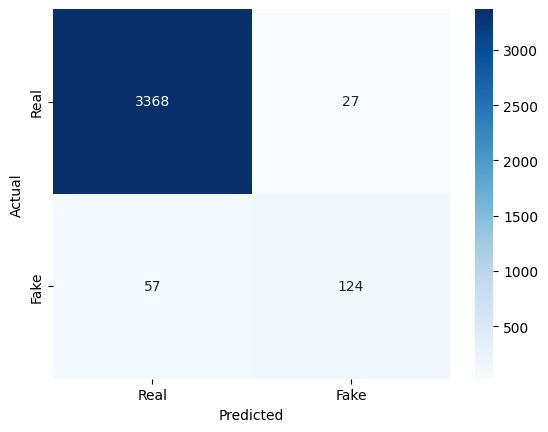

In [35]:
y_pred = (model.predict([X_test_text, X_test_numeric]) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()